In [2]:
import os
import numpy as np

import findspark
try:
    findspark.init()
except:
    PYSPARK_PATH = '../spark/spark-2.4.3-bin-hadoop2.7/' # change path to yours
    findspark.init(PYSPARK_PATH)
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import *
from pyspark.sql.functions import col, lower, regexp_replace, split, size, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType
from functools import reduce
import re

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

In [33]:
# df_path = "csv_data/top-10-sample-output-ores_features.csv"
df_path = "csv_data/sample-output-ores_features.csv"
df_features = spark.read.csv(df_path, inferSchema=True, header=True, multiLine=True, escape='"')

In [34]:
features_names = ['title',
                  'Stub',
                  'Start',
                  'C',
                  'B',
                  'GA',
                  'FA',
                  'n_words',
                  'level2',
                  'level3',
                  'level4',
                  'level5',
                  'level6',
                  'book_citations',
                  'journal_citations',
                  'n_internal_links',
                  'n_external_links',
                  'n_paragraphs',
                  'n_unreferenced',
                  'n_categories',
                  'n_images'
                 ]

In [35]:
vectorAssembler = VectorAssembler(inputCols=features_names[1:],
                                  outputCol="features")

df_features = vectorAssembler.setHandleInvalid("skip").transform(df_features)

In [36]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_features)

# rescale each feature to range [min, max].
scaled_features = scalerModel.transform(df_features)
scaled_features = scaled_features.select('scaled_features')

In [37]:
scaled_features.printSchema()
# scaled_features.limit(20).collect()

root
 |-- scaled_features: vector (nullable = true)



In [38]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans(featuresCol='scaled_features').setK(3).setSeed(1)
model = bkm.fit(scaled_features)

# Evaluate clustering.
cost = model.computeCost(scaled_features)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result. 
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 4334.322907773121
Cluster Centers: 
[4.41816342e-03 6.05871560e-02 4.21633284e-01 3.38226916e-01
 1.75860719e-01 1.33750949e-01 1.17404751e-01 6.27008492e-02
 3.01234662e-02 1.36211793e-02 2.09925492e-03 3.30402804e-04
 1.92161040e-02 1.08397259e-02 6.27340914e-02 3.51979696e-02
 9.14101683e-02 5.57199263e-03 3.70502802e-02 5.00000000e-01]
[1.03776352e-01 6.99572954e-01 2.02840145e-01 1.16077459e-01
 1.50231342e-02 5.88593182e-03 1.57850163e-02 2.51075234e-02
 8.53901939e-03 1.17022045e-02 4.14533041e-04 2.28602780e-04
 1.64920577e-03 4.38345830e-04 1.82235869e-02 2.33599902e-03
 1.99008041e-02 2.53795739e-04 1.11765796e-02 5.00000000e-01]
[9.23316569e-01 7.39366382e-02 8.38966812e-03 9.59163034e-03
 1.71153937e-03 1.26769030e-03 1.38980849e-03 2.92297845e-03
 7.12543104e-04 8.96799277e-04 2.08737763e-06 0.00000000e+00
 1.16296754e-04 2.70054481e-05 1.51846050e-03 1.81758052e-04
 2.92170157e-03 2.65182158e-05 1.22808903e-03 5.00000000e-01]


In [39]:
# get predictions and collect into the list
labels = model.transform(scaled_features).select('prediction')
labels = labels.collect() 
# create vanilla list with ints 
# instead of list with element type Rows
labels = list(map(lambda x: x.prediction, labels))

In [40]:
"""
Visualization with PCA
"""
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_features)

compressed = model.transform(df_features).select("pcaFeatures")
compressed.show(10)

+--------------------+
|         pcaFeatures|
+--------------------+
|[19884.2845406643...|
|[2141.58231948718...|
|[10819.1366918810...|
|[5274.36298090202...|
|[3033.26827065264...|
|[1790.08541020889...|
|[4679.62819741169...|
|[4881.89004518290...|
|[3326.15906935333...|
|[865.210217783942...|
+--------------------+
only showing top 10 rows



In [41]:
compressed = compressed.toPandas()
compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
compressed = compressed.pcaFeatures.values
compressed = np.stack(compressed, axis=0)

In [42]:
colors = {0: 'red', 1: 'green', 2: 'blue'}
colors = list(map(lambda x: colors[x], labels))

In [43]:
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

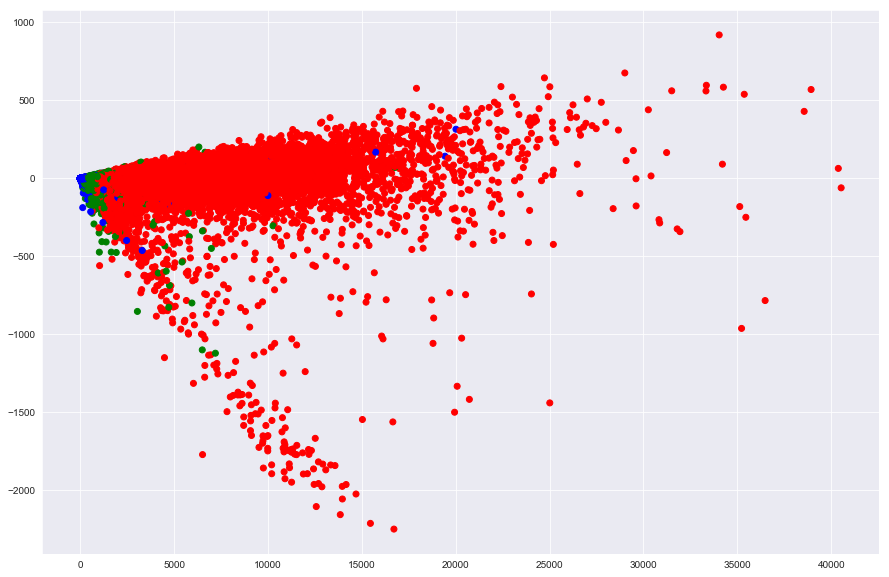

In [44]:
plt.scatter(*compressed.T, c=colors)